In [2]:
%load_ext autoreload

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xa
import lib.utilities as utl
import lib.wrf_tools as wtl

%autoreload 2

def tpot_from_N(Tb,N,z,dz):
	g0=9.80665
	tpot = Tb*np.exp((N**2/g0)*(z+dz))
	return tpot

def tpot_from_N_new(Tb,N,z):
    g0=9.80655
    tpot = Tb*np.exp((N**2/g0)*z)
    return tpot

def tpot_from_dth(Tb,dth,z,dThPer100m=False):
    if dThPer100m:     # this should be the standard
        dthperm  = 0.3/100. # calculate change of th per meter K m**-1
        tpot_arr = np.zeros(len(z))
        dzarr    = np.zeros(len(z))
        dzarr[0] = z[0]
        dzarr[1:]= z[1:]-z[:-1]
        dth_arr  = dzarr*dthperm
        tpot_arr[0]  = Tb+dth_arr[0]
        for n in range(1,len(z)):
            tpot_arr[n] = tpot_arr[n-1]+dth_arr[n]
    else:              # here we assume that the caller specifies dTh according to the dz spacing
        dth_arr  = np.arange(1.,len(z)+1,1.)
        tpot_arr = Tb+dth_arr*dth
    return tpot_arr

# calculate density when pressure and potential temperature are given
# uses ideal gas equation
def rho_ideal_gas(p,th):
    RS  = 287.058 # specific gas constant in  J/kgK
    t   = t_from_tpot(th,p)
    rho = p/(RS*t)
    
    return rho

def deltap(rho,deltaz):
    
    if deltaz == 0:
        dp = 0
    else:
        dp = -rho*deltaz*9.81 
    
    return dp

def calculate_saturation_pressures(t):
	#result = 611.21 * 10**((7.5*t)/(t+237.3))
	result = 610.8*np.exp(17.27*t/(t+237.3)) # in Pa, t in deg. C
	return result

def calculate_qv_from_rh(rh,prs_sat,prs):
	c_Rwv  = 	461.5 # J/kgK spec. gas constant for water vapor
	c_Rair =	286.9 # J/kgK spec. gas constant for dry air
	result = rh/100.0 * ((c_Rair/c_Rwv)*(prs_sat/prs))
	return result

def t_from_tpot(tpot,p):
	t = tpot/((10.0**5.0/p)**(2.0/7.0))
	return t


def barometric_formula(h):
	M=0.0289644		# molar mass of air, kg/mol
	g0=9.80665		# gravitational acceleration m/s^2
	R=8.3144598		# universal gas constant, J/(mol*K)

	if 0<= h and h < 11000:
		Tb = 288.15
		Lb = -0.0065
		Pb = 101325.0
		hb = 0.0
		b=0
	elif 11000 <= h and h < 20000:
		Tb = 216.65
		Lb = 0.000001
		Pb = 22632.10
		hb = 11000.0
		b=1
	elif 20000 <= h and h < 32000:
		Tb = 216.65
		Lb = 0.001
		Pb = 5474.89
		hb = 20000.0
		b=2
	elif 32000 <= h and h < 47000:
		Tb = 228.65
		Lb = 0.0028
		Pb = 868.02
		hb = 32000.0
		b=3
	elif 47000 <= h and h < 51000:
		Tb = 270.65
		Lb = 0.000001
		Pb = 110.91
		hb = 47000.0
		b=4
	elif 51000 <= h and h < 71000:
		Tb = 270.65
		Lb = -0.0028
		Pb = 66.94
		hb = 51000.0
		b=5
	else:
		Tb = 214.65
		Lb = -0.002
		Pb = 3.96
		hb = 70000.0
		b=6

	P = Pb*(Tb/(Tb+Lb*(h-hb)))**(g0*M/(R*Lb))		# as seen in, e.g. https://en.wikipedia.org/wiki/Barometric_formula
	return P

def p_from_th(p0,z_arr,th_arr):
    p_arr = np.zeros(len(z_arr))
    
    for n, z in enumerate(z_arr):

        if n == 0:
            pm1 = p0
            dz  = 0
        else:
            pm1 = p_arr[n-1]
            dz  = z_arr[n]-z_arr[n-1]

        rho      = rho_ideal_gas(pm1,th_arr[n])
        p_arr[n] = pm1+deltap(rho=rho,deltaz=dz)

    return p_arr

# Generate a WRF sounding

vertical wavelength: 12566
dimensionless inverse mountain height: 2.00


"\nfh = open(outfile,'w')\nfh.write('{:10.2f}{:12.2f}{:12.2e}\n'.format(p_arr[0]/100,Tb,qv))\nfor n in range(Nz):\n    fh.write('{:10.2f}{:12.2f}{:12.2e}{:12.2f}{:12.2f}\n'.format(z_arr[n],th_arr[n],qv_arr[n],u_arr[n],v_arr[n]))\nprint('wrote '+outfile)\n"

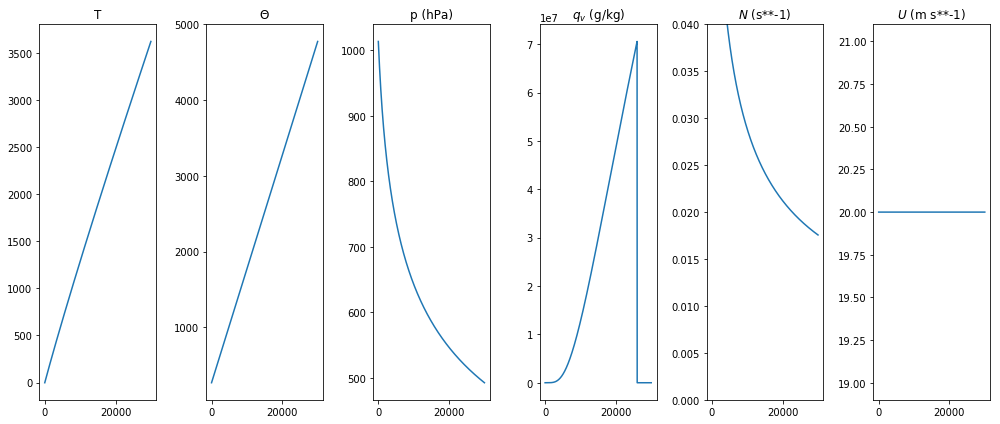

In [4]:
# set parameters
N  = 0.01
ws = 20.0
Tb = 270
p0  = 101325  #hPa surface pressure
zmax = 30000
dz   = 50.0
rh   = 100.
rhtop=30000

z_arr  = np.arange(0,zmax+dz,dz)
Nz     = len(z_arr)
th_arr  = tpot_from_dth(Tb,0.15,z_arr)# tpot_from_N(Tb,N,z_arr,dz) 
th_arr2 = tpot_from_N(Tb,N,z_arr,dz) 
th_arr3 = tpot_from_N_new(Tb,N,z_arr)
qv_arr = z_arr*0
u_arr  = np.ones(Nz)*ws
v_arr  = np.zeros(Nz)
p_arr  = np.zeros(Nz)
N_arr  = np.zeros(Nz-1)

p_arr  = p_from_th(p0=p0,z_arr=z_arr,th_arr=th_arr)
for n, z in enumerate(z_arr):
    if n < len(z_arr)-1:
        N_arr[n]  = np.sqrt(9.81*(np.log(th_arr[n+1])-np.log(th_arr[n]))/(z_arr[n+1]-z_arr[n]))
t_arr    = t_from_tpot(th_arr,p_arr)
psat_arr = calculate_saturation_pressures(t_arr-273.15)
qv_arr   = calculate_qv_from_rh(rh,psat_arr,p_arr)*1000. # wrf wants it in g/kg
qv_arr[np.isinf(qv_arr)]=0.0 # remove potential infinities

print('vertical wavelength: {:4.0f}'.format(2*np.pi*ws/N))
print('dimensionless inverse mountain height: {:1.2f}'.format(ws/(N*1000.)))


qv_arr[z_arr>=26000] = 0

if rhtop != 0:
    qv = qv_arr[0]+qv_arr[0]-qv_arr[1]
else:
    qv = 0

f, ax = plt.subplots(1,6,figsize=(14,6))
ax[0].plot(z_arr, t_arr-273.15)
ax[1].plot(z_arr, th_arr)
ax[2].plot(z_arr, p_arr/100)
ax[3].plot(z_arr, qv_arr)
ax[4].plot(z_arr[:-1], N_arr)
ax[5].plot(z_arr,u_arr)
           
ax[0].set_title('T')
ax[1].set_title('$\Theta$')
ax[2].set_title('p (hPa)')
ax[3].set_title('$q_v$ (g/kg)')
ax[4].set_title('$N$ (s**-1)')
ax[5].set_title('$U$ (m s**-1)')

ax[4].set_ylim(0,0.04)

plt.tight_layout()

# write the sounding to file
outfile='input_sounding_{:n}_{:n}_{:2.4f}_{:2.2f}'.format(Tb,ws,np.mean(N_arr),rh/100.)

'''
fh = open(outfile,'w')
fh.write('{:10.2f}{:12.2f}{:12.2e}\n'.format(p_arr[0]/100,Tb,qv))
for n in range(Nz):
    fh.write('{:10.2f}{:12.2f}{:12.2e}{:12.2f}{:12.2f}\n'.format(z_arr[n],th_arr[n],qv_arr[n],u_arr[n],v_arr[n]))
print('wrote '+outfile)
'''

In [14]:
import sys as sys
np.set_printoptions(threshold=sys.maxsize)
np.save('../fieldcompare/standard_pressure_0-2000m',p_arr[0:2000])
print(p_arr[0:2000])

[101325.         101312.23747512 101299.48317636 101286.73709388
 101273.99921789 101261.2695386  101248.54804625 101235.83473109
 101223.12958339 101210.43259343 101197.7437515  101185.06304794
 101172.39047307 101159.72601725 101147.06967084 101134.42142423
 101121.78126782 101109.14919203 101096.52518729 101083.90924406
 101071.30135281 101058.70150401 101046.10968817 101033.5258958
 101020.95011745 101008.38234366 100995.82256499 100983.27077203
 100970.72695538 100958.19110565 100945.66321347 100933.14326949
 100920.63126438 100908.12718881 100895.63103348 100883.1427891
 100870.66244639 100858.18999611 100845.725429   100833.26873584
 100820.81990743 100808.37893457 100795.94580808 100783.5205188
 100771.10305758 100758.6934153  100746.29158282 100733.89755107
 100721.51131094 100709.13285338 100696.76216932 100684.39924974
 100672.0440856  100659.6966679  100647.35698765 100635.02503586
 100622.70080359 100610.38428188 100598.07546179 100585.77433442
 100573.48089086 100561.1951

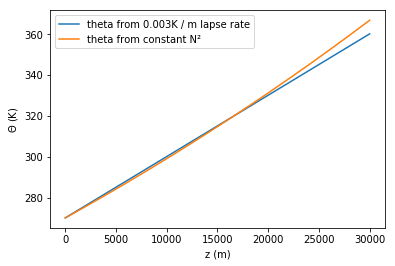

In [24]:
plt.plot(z_arr,th_arr,label='theta from 0.003K / m lapse rate')
plt.plot(z_arr,th_arr2,label='theta from constant N²')
plt.xlabel('z (m)')
plt.ylabel('$\Theta$ (K)')
plt.legend()

In [14]:
th_arr3

# wrf sounding to icar input file
forcing resolution = icar resolution

In [ ]:
def get_topo(x,topo='witch',a0=1000,a1=20000):
    if topo == 'witch':
        h=a0*(a1**2/(x**2+a1**2))				# topography
    elif topo == 'triangle':
        if np.abs(x) <= a1/2.0:
                k = np.sign(x)
                h = -np.sign(x)*x*2.0*(a0/a1)+a0
        else:
            h = 0.0
    elif topo=="sine":
        h=a0/2.0+a0/2.0*np.sin((np.pi/a1)*(x-a1/2.0))		# sine with the minimum at domain center
    return h

In [ ]:
# set basic characteristics
nrz    = 10    # vertically use only every nrz-th entry from above arrays (to preserve space) for LR forcing
nrx    = 10    # horizontally only use every nrx-th entry for LR forcing

# choose nx and ny large enough so that n < 2*smthwindow+1 where smoothing window is the number of cells
# icar smooths the wind field over
nx     = 404   # use even numbers for now! x extension of HR domain 
ny     = 104    # use even numbers for now! y extension of HR domain
dx     = 2000  # HR forcing dx => LR forcing dx is therefore nrx*dx

nx_lr  = int(nx/nrx)
ny_lr  = int(ny/nrx)

ntime  = 6

nlvls  = len(z_arr[::nrz])   # LR forcing level number

lonc   = 90.
latc   = 0.

# find HR domain horizontal spacing in degrees by calling haversine until
# we find the angle that best approximates the distance
test_min=99999.0
angle = None

for test_llon in np.arange(0.0,0.25,0.000001):
    test_result1 = utl.haversine(lonc-test_llon/2.0,latc,lonc+test_llon/2.0,latc)
    test_result2 = np.abs(test_result1 - dx)
    if  test_result2 < test_min:
        test_min = test_result2
        angle = test_llon

ddeg=angle

In [ ]:
lons_hr = np.arange(-nx/2,nx/2,1)*ddeg+lonc
lats_hr = np.arange(-ny/2,ny/2,1)*ddeg+latc
xs_hr   = np.arange(-nx/2,nx/2,1)*dx
xx, xy  = np.meshgrid(lons_hr,lats_hr)

# calculate LR grid and add a buffer that is ddeg*nrx/2.0 around the HR domain
lons_lr = np.linspace(np.min(lons_hr)-ddeg/2.0*nrx,np.max(lons_hr)+ddeg/2.0*nrx,nx_lr)
lats_lr = np.linspace(np.min(lats_hr)-ddeg/2.0*nrx,np.max(lats_hr)+ddeg/2.0*nrx,ny_lr)
xx_lr, xy_lr  = np.meshgrid(lons_lr,lats_lr)

In [ ]:
plt.scatter(xx,xy,s=1)
plt.scatter(xx_lr,xy_lr)

In [ ]:
# forcing data
time   = np.arange(0,ntime,1)
qvapor = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
qcloud = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)
qice   = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)
u      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
v      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)

t      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
tsk    = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)
pb     = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)
ph     = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
p      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
phb    = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr)

sp     = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # set

xlong  = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # set
xlat   = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # set
hgt    = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # should be zero for background

# HR data
xlong_m  = np.zeros(ny*nx).reshape(ny,nx) # set
xlat_m   = np.zeros(ny*nx).reshape(ny,nx) # set
hgt_m    = np.zeros(ny*nx).reshape(ny,nx) # set
landmask = np.zeros(ny*nx).reshape(ny,nx)

xlong_m = xx
xlat_m  = xy


for i in range(ntime):
    sp[i,:,:] = p_arr[0]
    xlong[i,:,:] = xx_lr
    xlat[i,:,:] = xy_lr
    for k in range(nx_lr):
        hgt_m[:,k] = get_topo(x=xs[k],a0=1000.,a1=20000.,topo='witch')
        for j in range(ny_lr):
            qvapor[i,:,j,k]   = qv_arr[::nrz]/1000.
            u[i,:,j,k]        = u_arr[::nrz]
            t[i,:,j,k]        = th_arr[::nrz]
            ph[i,:,j,k]       = z_arr[::nrz]
            p[i,:,j,k]        = p_arr[::nrz]

            # generate HR topography
for k in range(nx):
    hgt_m[:,k] = get_topo(x=xs[k],a0=1000.,a1=20000.,topo='witch')

In [ ]:
icar_sounding_ds	= xa.Dataset(
                        data_vars={
                            'HGT':(['Time','south_north','west_east'],hgt),
                            'XLONG':(['Time','south_north','west_east'],xlong),
                            'XLAT':(['Time','south_north','west_east'],xlat),
                            'P':(['Time','bottom_top','south_north','west_east'],p),
                            'T':(['Time','bottom_top','south_north','west_east'],t),
                            'PH':(['Time','bottom_top','south_north','west_east'],ph),
                            'U':(['Time','bottom_top','south_north','west_east'],u),
                            'V':(['Time','bottom_top','south_north','west_east'],v),
                            'sp':(['Time','south_north','west_east'],sp),
                            'PB':(['Time','bottom_top','south_north','west_east'],pb),
                            'PHB':(['Time','bottom_top','south_north','west_east'],phb),
                            'QVAPOR':(['Time','bottom_top','south_north','west_east'],qvapor),
                            'QCLOUD':(['Time','bottom_top','south_north','west_east'],qcloud),
                            'QICE':(['Time','bottom_top','south_north','west_east'],qice),
                            'TSK':(['Time','bottom_top','south_north','west_east'],tsk)
                        },
                        coords={
                            'Time':time,
                            'bottom_top':np.arange(0,nlvls,1.0),
                            'south_north':np.arange(0,ny_lr,1.0),
                            'west_east':np.arange(0,nx_lr,1.0)
                        }
                    )

icar_hr_ds	= xa.Dataset(
                        data_vars={
                            'HGT_M':(['south_north','west_east'],hgt_m),
                            'XLONG_M':(['south_north','west_east'],xlong_m),
                            'XLAT_M':(['south_north','west_east'],xlat_m),
                            'LANDMASK':(['south_north','west_east'],landmask)
                        },
                        coords={
                            'Time':time,
                            'bottom_top':np.arange(0,nlvls,1.0),
                            'south_north':np.arange(0,ny,1.0),
                            'west_east':np.arange(0,nx,1.0)
                        }
                    )

In [ ]:
icar_sounding_ds.to_netcdf('./icar_sounding{:s}.nc'.format(outfile.replace('input_sounding','')),format='NETCDF4')
icar_hr_ds.to_netcdf('./icar_hr{:s}.nc'.format(outfile.replace('input_sounding','')),format='NETCDF4')

In [ ]:
icar_hr_ds.XLONG_M

# Read a WRF sounding

In [ ]:
snd_arrs = [
    np.genfromtxt('../cloud_plots/data/external/wrf_out/ethan/dry/input_sounding',skip_header=1),
    #np.genfromtxt('../cloud_plots/data/external/wrf_out/wethans_settings/a0_1000/a1_20000/280_10_0.0095/input_sounding',skip_header=1)
    #np.genfromtxt('./input_sounding_280_10_0.0095_6.7',skip_header=1)
]


f, ax = plt.subplots(1,6,figsize=(12,6))

for snd_arr in snd_arrs:

    z_arr = snd_arr[:,0]
    th_arr = snd_arr[:,1]
    qv_arr = snd_arr[:,2]
    u_arr = snd_arr[:,3]
    v_arr = snd_arr[:,4]
    Nsnd = snd_arr.shape[0]
    p_arr = np.zeros(Nsnd)
    t_arr = np.zeros(Nsnd)

    N_arr = np.zeros(snd_arr.shape[0]-1)
    for n in range(0,snd_arr.shape[0]-1):
        N_arr[n] = np.sqrt(9.81*(np.log(th_arr[n+1])-np.log(th_arr[n]))/(z_arr[n+1]-z_arr[n]))

    p_arr = p_from_th(p0=100000,th_arr=th_arr,z_arr=z_arr)
    t_arr = t_from_tpot(p=p_arr,tpot=th_arr)

    ax[0].plot(z_arr, t_arr-273.15)
    ax[1].plot(z_arr, th_arr)
    ax[2].plot(z_arr, p_arr/1000)
    ax[3].plot(z_arr, qv_arr)
    ax[4].plot(z_arr[:-1], N_arr)
    ax[5].plot(z_arr, u_arr)

    ax[0].set_title('T')
    ax[1].set_title('$\Theta$')
    ax[2].set_title('p (hPa)')
    ax[3].set_title('$q_v$ (kg/kg)')
    ax[4].set_title('$N$ (s**-1)')
    ax[5].set_title('u (m**s-1)')
    


    ax[4].set_ylim(0,0.04)

plt.tight_layout()

## read a wrfinput_d01 file and modify it

In [ ]:
# look up byte datetime needed for wrfinput in a pregenerated table.
# I just don't know yet how to best automate this byte generation and have no time

byteTimesteps=[
    b'0001-01-01_00:00:00',
    b'0001-01-01_01:00:00',
    b'0001-01-01_02:00:00',
    b'0001-01-01_03:00:00',
    b'0001-01-01_04:00:00',
    b'0001-01-01_05:00:00',
    b'0001-01-01_06:00:00',
    b'0001-01-01_07:00:00',
    b'0001-01-01_08:00:00',
    b'0001-01-01_09:00:00',
    b'0001-01-01_10:00:00',
    b'0001-01-01_11:00:00',
    b'0001-01-01_12:00:00',
    b'0001-01-01_13:00:00',
    b'0001-01-01_14:00:00',
    b'0001-01-01_15:00:00',
    b'0001-01-01_16:00:00',
    b'0001-01-01_17:00:00',
    b'0001-01-01_18:00:00',
    b'0001-01-01_19:00:00',
    b'0001-01-01_20:00:00',
    b'0001-01-01_21:00:00',
    b'0001-01-01_22:00:00',
    b'0001-01-01_23:00:00',
    b'0001-01-02_00:00:00',
    b'0001-01-02_01:00:00',
    b'0001-01-02_02:00:00',
    b'0001-01-02_03:00:00',
    b'0001-01-02_04:00:00',
    b'0001-01-02_05:00:00',
    b'0001-01-02_06:00:00',
    b'0001-01-02_07:00:00',
    b'0001-01-02_08:00:00',
    b'0001-01-02_09:00:00',
    b'0001-01-02_10:00:00',
    b'0001-01-02_11:00:00',
    b'0001-01-02_12:00:00',
    b'0001-01-02_13:00:00',
    b'0001-01-02_14:00:00',    
]

In [ ]:
NTnew = 37

wrfin_ds = xa.open_dataset('../cloud_plots/data/external/icar_vs_wrf/wet/WRF/dc.1_25000._20000._270_20_0.0097_1.00_mp8_WRF3.4/wrfinput_d01')
wrfinNew_ds = xa.Dataset()
nVar = 0
for var in wrfin_ds.data_vars:
    if wrfin_ds[var].dims[0]=='Time' and var != 'Times':
        shape = wrfin_ds[var].shape
        dims  = wrfin_ds[var].dims
        Nshape = len(shape)
        coordDict = {}
        
        
        newShape    = [0]*Nshape     # new shape - list of length Nshape with integers
        newShape[0] = NTnew
        
        Ntot = NTnew
        
        for ndim in range(1,Nshape):
            newShape[ndim]  = shape[ndim]
            Ntot           *= shape[ndim]
            coordDict[dims[ndim]] = wrfin_ds[dims[ndim]].values
            
        newShape    = tuple(newShape)

        print('{:10s} {:20s} {:20s}'.format(var,str(shape),str(newShape)))
                
        newVar = np.zeros(Ntot)
        
        if Nshape > 1:
            newVar = newVar.reshape(newShape)
            
        if var != 'Times':
            for n in range(NTnew):   # set variable at timestep n to it's value at timestep zero
                if Nshape > 1:       # here we assign values for multidimensional variables
                    if var != 'QVAPOR':
                        newVar[n,:] = wrfin_ds[var][0]
                    else:
                        if n > 6:
                            newVar[n,:] = wrfin_ds[var][0]
                        else:
                            print('  setting QVAPOR to zero at t={:n}'.format(n))

                else:                # and here for vars with only one dimension
                    newVar[n] = wrfin_ds[var][0]
                    
            wrfadd_ds = xa.Dataset(
                        data_vars = {var:(dims,newVar)},
                        coords    = coordDict
                        )
            wrfinNew_ds = xa.merge(
                [wrfinNew_ds,wrfadd_ds],
                join='outer'
            )
            wrfinNew_ds[var].attrs = wrfin_ds[var].attrs

        nVar+=1
    elif wrfin_ds[var].dims[0]!='Time':       # here we just merge the non time dependent variables
        wrfinNew_ds = xa.merge(
            [wrfinNew_ds,wrfin_ds[var]],
            join='outer'
        )
        wrfinNew_ds[var].attrs = wrfin_ds[var].attrs
        print('{:10s}'.format(var))
        
        nVar+=1


In [ ]:
# Time needs to be a byte array, so we just treat it differently here
timeVar = []
for n in range(NTnew):
    timeVar.append(byteTimesteps[n])

wrfinNewTime_ds = xa.Dataset(
                    data_vars = {'Times':(['Time'],timeVar)},
                  )

#wrfinNew_ds = xa.merge([wrfinNew_ds,wrfinNewTime_ds])

In [ ]:
wrfinNew_ds = xa.merge([wrfinNew_ds,wrfinNewTime_ds])

# copy the general attributes
wrfinNew_ds.attrs = wrfin_ds.attrs   # must be AFTER merging with wrfinNewTime_ds - otherwise attributes vanish

In [ ]:
wrfinNew_ds.to_netcdf('./wrfinput_d01_modified',format='NETCDF3_64BIT')

## convert WRF output to an ICAR forcing

In [3]:
wrfout_ds = wtl.open_wrf('../cloud_plots/data/external/icar_vs_wrf/wet/WRF/dc.1_25000._20000._270_20_0.0097_1.00/')

In [4]:
wrfoutd_ds = wtl.destagger_wrf(wrfout_ds)

In [5]:
# set basic characteristics
nrz    = 1    # needs to be 1 here
nrx    = 1    # needs to be 1 here

# choose nx and ny large enough so that n < 2*smthwindow+1 where smoothing window is the number of cells
# icar smooths the wind field over
nx     = len(wrfoutd_ds.west_east)   # use even numbers for now! x extension of HR domain 
ny     = 104    # use even numbers for now! y extension of HR domain
dx     = 2000   # HR forcing dx => LR forcing dx is therefore nrx*dx

nywrf  = 1      # y slice of WRF used to set all y slices of ICAR forcing
ntwrf  = 6      # timestep in WRF that is to be used as initial state of ICAR

nx_lr  = int(nx/nrx)
ny_lr  = int(ny/nrx)

ntime  = 6

nlvls  = len(wrfoutd_ds.bottom_top)   # LR forcing level number

lonc   = 90.
latc   = 0.

# find HR domain horizontal spacing in degrees by calling haversine until
# we find the angle that best approximates the distance
test_min=99999.0
angle = None

for test_llon in np.arange(0.0,0.25,0.000001):
    test_result1 = utl.haversine(lonc-test_llon/2.0,latc,lonc+test_llon/2.0,latc)
    test_result2 = np.abs(test_result1 - dx)
    if  test_result2 < test_min:
        test_min = test_result2
        angle = test_llon

ddeg=angle

In [6]:
lons_hr = np.arange(-nx/2,nx/2,1)*ddeg+lonc
lats_hr = np.arange(-ny/2,ny/2,1)*ddeg+latc
xs_hr   = np.arange(-nx/2,nx/2,1)*dx
xx, xy  = np.meshgrid(lons_hr,lats_hr)

# calculate LR grid and add a buffer that is ddeg*nrx/2.0 around the HR domain
lons_lr = np.linspace(np.min(lons_hr)-ddeg/2.0*nrx,np.max(lons_hr)+ddeg/2.0*nrx,nx_lr)
lats_lr = np.linspace(np.min(lats_hr)-ddeg/2.0*nrx,np.max(lats_hr)+ddeg/2.0*nrx,ny_lr)
xx_lr, xy_lr  = np.meshgrid(lons_lr,lats_lr)

In [7]:
# set parameters needed for the background state. basically we need only the microphysics fields from WRF
# WRF output should be from a WRF run with a sounding like this.

N     = 0.01
ws    = 20.0
Tb    = 270
p0    = 101325  #hPa surface pressure
zmax  = 30000
dz    = 50.0
rh    = 100.
rhtop = 30000

# use z spacings from leftmost gridpoint in wrfoutput 
z_arr  = wrfoutd_ds.Z[0,:,nywrf,0].values

Nz     = len(z_arr)

# we can only use this th array at the domain boundaries
# everywhere else we have to calculate based on the local elevations
th_arr = tpot_from_dth(Tb,0.3,z_arr,dThPer100m=True)  # 0.3/100m <=> N=0.01 s**-1

qv_arr = z_arr*0
u_arr  = np.ones(Nz)*ws
p_arr  = np.zeros(Nz)
p_arr  = p_from_th(p0=p0,z_arr=z_arr,th_arr=th_arr)
N_arr  = np.zeros(Nz-1)

for n, z in enumerate(z_arr):
    if n < len(z_arr)-1:
        N_arr[n]  = np.sqrt(9.81*(np.log(th_arr[n+1])-np.log(th_arr[n]))/(z_arr[n+1]-z_arr[n]))
t_arr    = t_from_tpot(th_arr,p_arr)
psat_arr = calculate_saturation_pressures(t_arr-273.15)
qv_arr   = calculate_qv_from_rh(rh,psat_arr,p_arr)
qv_arr[np.isinf(qv_arr)]=0.0 # remove potential infinities


In [8]:
# forcing data
time   = np.arange(0,ntime,1)
qvapor = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
qcloud = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
qice   = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set

qrain = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
qsnow = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
qgrau = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
nice  = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
nrain = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set

u      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
v      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # no set

t      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
tsk    = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # no set
pb     = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # no set
ph     = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
p      = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # set
phb    = np.zeros(ntime*nlvls*ny_lr*nx_lr).reshape(ntime,nlvls,ny_lr,nx_lr) # no set

sp     = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # set

xlong  = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) 
xlat   = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) 
hgt    = np.zeros(ntime*ny_lr*nx_lr).reshape(ntime,ny_lr,nx_lr) # should be zero for background

# HR data
xlong_m  = np.zeros(ny*nx).reshape(ny,nx) 
xlat_m   = np.zeros(ny*nx).reshape(ny,nx) 
hgt_m    = np.zeros(ny*nx).reshape(ny,nx) 
landmask = np.zeros(ny*nx).reshape(ny,nx)

xlong_m = xx
xlat_m  = xy

In [9]:
# set the background state. TPOT has to be calculated from the WRF elevations in order to get a linear increase of
# TPOT with height that starts at a base temperature of Tb

for i in range(ntime):
    sp[i,:,:] = p_arr[0]
    
    for j in range(ny_lr):
        ph[i,:,j,:]       = wrfoutd_ds.Z[ntwrf,:,nywrf,:]
        for k in range(nx_lr):
            u[i,:,j,k]        = u_arr[::nrz]
            
            #ph[i,:,j,k]       = wrfoutd_ds.Z[ntwrf,:,nywrf,k] #z_arr[::nrz]
            t[i,:,j,k]        = tpot_from_dth(Tb,0.3,ph[i,:,j,k],dThPer100m=True) #th_arr[::nrz]

            #p[i,:,j,k]        = p_arr[::nrz]
        if j%10 == 0:   
            utl.mwrite('{:2.1f}% '.format(100.*(j/(ny_lr-1))))
utl.mwrite('\n')

0.0% 9.7% 19.4% 29.1% 38.8% 48.5% 58.3% 68.0% 77.7% 87.4% 97.1% 0.0% 9.7% 19.4% 29.1% 38.8% 48.5% 58.3% 68.0% 77.7% 87.4% 97.1% 0.0% 9.7% 19.4% 29.1% 38.8% 48.5% 58.3% 68.0% 77.7% 87.4% 97.1% 0.0% 9.7% 19.4% 29.1% 38.8% 48.5% 58.3% 68.0% 77.7% 87.4% 97.1% 0.0% 9.7% 19.4% 29.1% 38.8% 48.5% 58.3% 68.0% 77.7% 87.4% 97.1% 0.0% 9.7% 19.4% 29.1% 38.8% 48.5% 58.3% 68.0% 77.7% 87.4% 97.1% 


In [10]:
# set everything at ICAR forcing t=0 to a perdetermined WRF timestep
# and set it for all timesteps where possible

hgt_m[:,:] = wrfoutd_ds.HGT[ntwrf,nywrf]


for j in range(ny_lr):
    qvapor[0,:,j] = wrfoutd_ds.QVAPOR[ntwrf,:,nywrf]
    qcloud[0,:,j] = wrfoutd_ds.QCLOUD[ntwrf,:,nywrf]
    qice[0,:,j]   = wrfoutd_ds.QICE[ntwrf,:,nywrf]
    
    qrain[0,:,j]  = wrfoutd_ds.QRAIN[ntwrf,:,nywrf]
    qsnow[0,:,j]  = wrfoutd_ds.QSNOW[ntwrf,:,nywrf]
    qgrau[0,:,j]  = wrfoutd_ds.QGRAUP[ntwrf,:,nywrf]
    nice[0,:,j]   = wrfoutd_ds.QNICE[ntwrf,:,nywrf]
    nrain[0,:,j]   = wrfoutd_ds.QNRAIN[ntwrf,:,nywrf]
    
    #u[0,:,j]      = wrfoutd_ds.Uds[ntwrf,:,nywrf]
    #t[0,:,j]      = wrfoutd_ds.TH[ntwrf,:,nywrf]
    #ph[0,:,j]     = wrfoutd_ds.Z[ntwrf,:,nywrf]
    #p[0,:,j]      = wrfoutd_ds.PTOT[ntwrf,:,nywrf]

In [11]:

for i in range(0,ntime):
    xlong[i,:] = xx_lr
    xlat[i,:] = xy_lr

# set microphysics fields at all later timesteps
# all except for qvapor remain at zero here, qvapor is set to whatever WRF has at timestep zero.
# this is usually the qv value for RH=100%

for i in range(1,ntime):
    for j in range(ny_lr):
        #for k in range(nx_lr):
        qvapor[i,:,j,:] = wrfoutd_ds.QVAPOR[0,:,nywrf,:]#qvapor[i,:,j,k] = qv_arr #
        
        #u[i,:,j]      = wrfoutd_ds.Uds[ntwrf,:,nywrf]
        #t[i,:,j]      = wrfoutd_ds.TH[ntwrf,:,nywrf]
        #ph[i,:,j]     = wrfoutd_ds.Z[ntwrf,:,nywrf]
        
        # use this to initialize t > 0 with the sounding
        p[i,:,j]      = wrfoutd_ds.PTOT[0,:,nywrf,:]
        t[i,:,j]      = wrfoutd_ds.TH[0,:,nywrf,:]
        # p[0,:,j]      = wrfoutd_ds.PTOT[0,:,nywrf,:]
        
        # this prescribes the P field for ICAR at t = 0 and later
        p[0,:,j]      = wrfoutd_ds.PTOT[ntwrf,:,nywrf,:]
        #p[i,:,j]      = wrfoutd_ds.PTOT[ntwrf,:,nywrf,:]
        
        # turn this on to prescribe the TH field for ICAR at t = 0 and later
        t[0,:,j]      = wrfoutd_ds.TH[ntwrf,:,nywrf,:]
        #t[i,:,j]      = wrfoutd_ds.TH[ntwrf,:,nywrf,:]
        
        # turn this on to prescribe the WRF windfield for ICAR (and use wind=0 as option)
        #u[i,:,j]      = wrfoutd_ds.Uds[ntwrf,:,nywrf,:]
        #u[0,:,j]      = wrfoutd_ds.Uds[ntwrf,:,nywrf,:]
    utl.mwrite('{:2.1f}% '.format(100.*(i/(ntime-1))))
utl.mwrite('\n')
#for k in range(nx):
#    hgt_m[:,k] = get_topo(x=xs[k],a0=1000.,a1=20000.,topo='witch')

20.0% 40.0% 60.0% 80.0% 100.0% 


In [12]:
icar_sounding_ds	= xa.Dataset(
                        data_vars={
                            'HGT':(['Time','south_north','west_east'],hgt),
                            'XLONG':(['Time','south_north','west_east'],xlong),
                            'XLAT':(['Time','south_north','west_east'],xlat),
                            'P':(['Time','bottom_top','south_north','west_east'],p),
                            'T':(['Time','bottom_top','south_north','west_east'],t),
                            'PH':(['Time','bottom_top','south_north','west_east'],ph),
                            'U':(['Time','bottom_top','south_north','west_east'],u),
                            'V':(['Time','bottom_top','south_north','west_east'],v),
                            'sp':(['Time','south_north','west_east'],sp),
                            'PB':(['Time','bottom_top','south_north','west_east'],pb),
                            'PHB':(['Time','bottom_top','south_north','west_east'],phb),
                            'QVAPOR':(['Time','bottom_top','south_north','west_east'],qvapor),
                            'QCLOUD':(['Time','bottom_top','south_north','west_east'],qcloud),
                            'QICE':(['Time','bottom_top','south_north','west_east'],qice),

                            'QRAIN':(['Time','bottom_top','south_north','west_east'],qrain),
                            'QSNOW':(['Time','bottom_top','south_north','west_east'],qsnow),
                            'QGRAU':(['Time','bottom_top','south_north','west_east'],qgrau),

                            'NICE':(['Time','bottom_top','south_north','west_east'],nice),
                            'NRAIN':(['Time','bottom_top','south_north','west_east'],nrain),
                            
                            'TSK':(['Time','bottom_top','south_north','west_east'],tsk)
                        },
                        coords={
                            'Time':time,
                            'bottom_top':np.arange(0,nlvls,1.0),
                            'south_north':np.arange(0,ny_lr,1.0),
                            'west_east':np.arange(0,nx_lr,1.0)
                        }
                    )

# don't use all data points from forcing - leads to error in ICAR. therefore we skip two points at each boundary

icar_hr_ds	= xa.Dataset(
                        data_vars={
                            'HGT_M':(['south_north','west_east'],hgt_m[2:-2,2:-2]),
                            'XLONG_M':(['south_north','west_east'],xlong_m[2:-2,2:-2]),
                            'XLAT_M':(['south_north','west_east'],xlat_m[2:-2,2:-2]),
                            'LANDMASK':(['south_north','west_east'],landmask[2:-2,2:-2])
                        },
                        coords={
                            'Time':time,
                            'bottom_top':np.arange(0,nlvls,1.0),
                            'south_north':np.arange(0,ny,1.0)[0:-4],
                            'west_east':np.arange(0,nx,1.0)[0:-4]
                        }
                    )

icar_extwinds	= xa.Dataset(
                        data_vars={
                            'HGT_M':(['south_north','west_east'],hgt_m),
                            'XLONG':(['south_north','west_east'],xlong_m),
                            'XLAT':(['south_north','west_east'],xlat_m),
                            'U':(['Time','bottom_top','south_north','west_east'],u),
                            'V':(['Time','bottom_top','south_north','west_east'],v),
                        },
                        coords={
                            'Time':time,
                            'bottom_top':np.arange(0,nlvls,1.0),
                            'south_north':np.arange(0,ny,1.0),
                            'west_east':np.arange(0,nx,1.0)
                        }
                    )

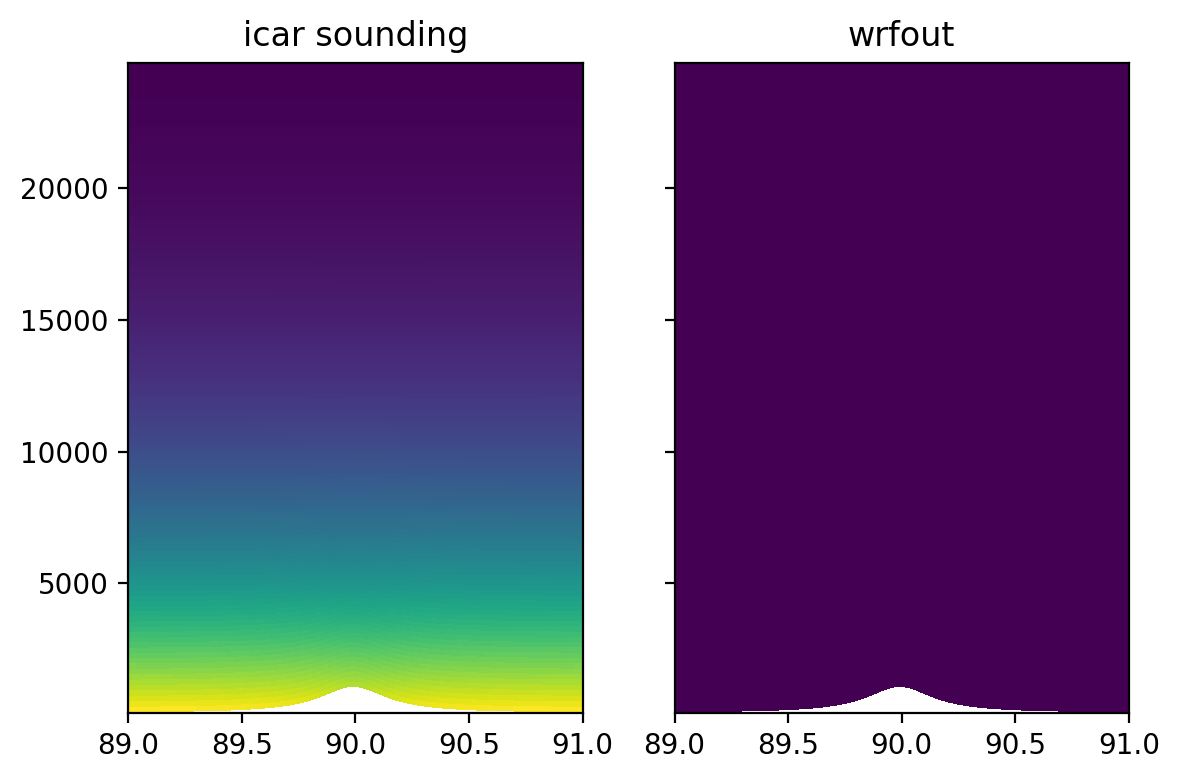

In [29]:
xlong_dummy = np.linspace(86.42978,86.42978+7.1224594,len(wrfoutd_ds.XLONG[0,1,:]))
ts=1
f,axarr = plt.subplots(1,2,dpi=200,sharey=True,sharex=True)
qw  = 'P'
qs  = 'P'

vmax=np.nanmax([np.nanmax(icar_sounding_ds[qs][ts,:,52,:].values)])
vmin=np.nanmin([np.nanmin(icar_sounding_ds[qs][ts,:,52,:].values)])
axarr[0].pcolormesh(icar_sounding_ds['XLONG'][0,52],icar_sounding_ds['PH'][ts,:,52,:],icar_sounding_ds[qs][ts,:,52,:],vmin=vmin,vmax=vmax)
axarr[1].pcolormesh(xlong_dummy,wrfoutd_ds.Z[6,:,1,:].values,wrfoutd_ds[qw][6,:,1,:].values,vmin=vmin,vmax=vmax)
axarr[0].set_title('icar sounding')
axarr[1].set_title('wrfout')
#axarr[2].set_title('icar')
#axarr[-1].set_ylim(0,6000)
axarr[0].set_xlim(89.,91.)
plt.tight_layout()

In [30]:
icar_sounding_ds.to_netcdf('icar_sounding_allmpf_th_p_from_wrf_270_20_0.0097_1.00.nc')

In [ ]:
icar_extwinds.to_netcdf('icar_extwinds_from_wrf_270_20_0.0097_1.00.nc')

In [ ]:
icar_hr_ds.to_netcdf('icar_hr_mpf_from_wrf_270_20_0.0097_1.00.nc')

In [ ]:
plt.scatter(icar_sounding_ds.XLONG,icar_sounding_ds.XLAT,s=1)
plt.scatter(icar_hr_ds.XLONG_M,icar_hr_ds.XLAT_M,s=1)

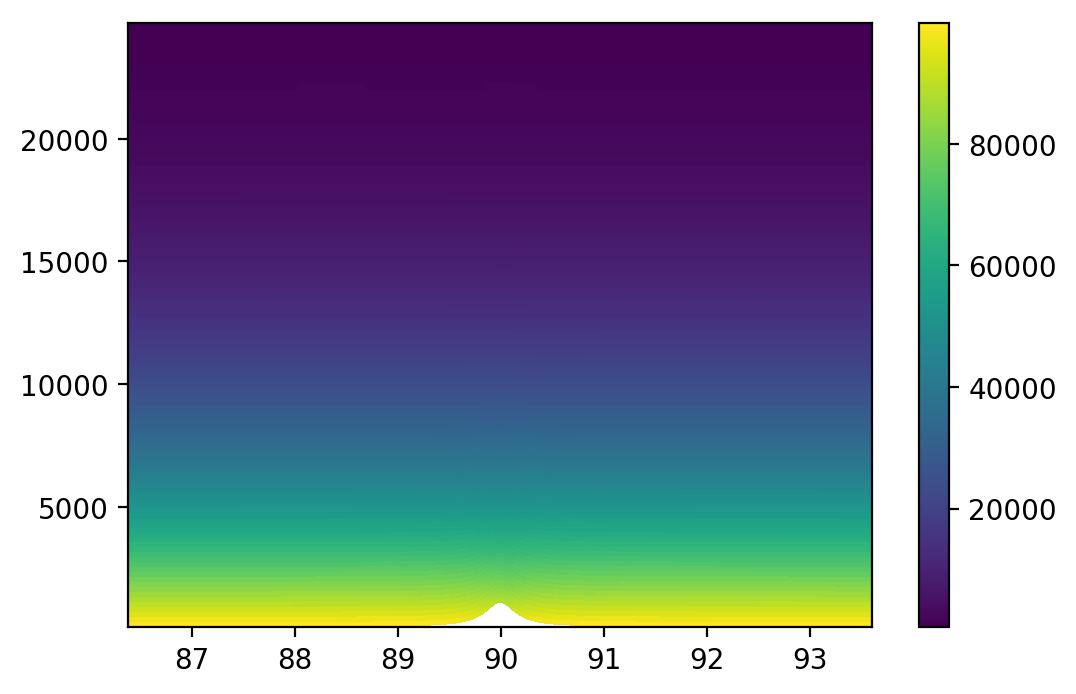

In [40]:
f,ax = plt.subplots(1,1,dpi=200)
pcm = ax.pcolormesh(icar_sounding_ds['XLONG'][0,52],icar_sounding_ds['PH'][0,:,52,:],icar_sounding_ds['P'][0,:,52,:])
plt.colorbar(pcm)

In [24]:
ids = xa.open_dataset('../cloud_plots/data/external/icar_vs_wrf/wet/ICAR/rh100_full_a01000m_a120000_ws20_N0.01_Tb270.0_witch_5c1vn1allmpf/witch_5c1vn1allmpf_nz43/icar_out_cs.nc')
#icar_sounding_ds = xa.open_dataset('./icar_sounding_allmpf_from_wrf_270_20_0.0097_1.00_correctz.nc')

In [ ]:
plt.pcolormesh(ids['lon'],ids['z'],ids['qc'][0,:])
plt.ylim(0,8000)

NameError: name 'ids' is not defined

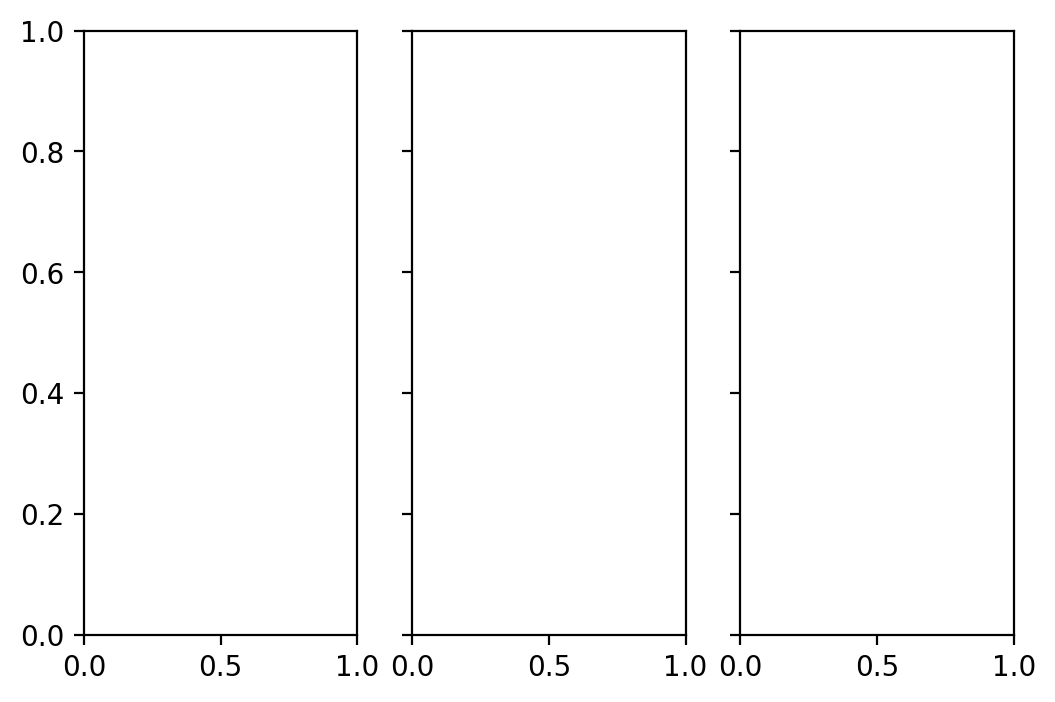

In [21]:
xlong_dummy = np.linspace(86.42978,86.42978+7.1224594,len(wrfoutd_ds.XLONG[0,1,:]))

f,axarr = plt.subplots(1,3,dpi=200,sharey=True,sharex=True)
ts = 0
qw  = 'TH'
qs  = 'T'
qi  = 'th'

vmax=np.nanmax([np.nanmax(icar_sounding_ds[qs][ts,:,52,:].values),np.nanmax(wrfoutd_ds[qw][6,:,1,:].values),np.nanmax(ids[qi][0,:])])
axarr[0].pcolormesh(icar_sounding_ds['XLONG'][0,52],icar_sounding_ds['PH'][ts,:,52,:],icar_sounding_ds[qs][ts,:,52,:])#,vmin=0,vmax=vmax)
axarr[1].pcolormesh(xlong_dummy,wrfoutd_ds.Z[6,:,1,:].values,wrfoutd_ds[qw][6,:,1,:].values)#,vmin=0,vmax=vmax)
#axarr[2].pcolormesh(ids['lon'],ids['z'],ids[qi][0,:],vmin=0,vmax=vmax)
axarr[0].set_title('icar sounding')
axarr[1].set_title('wrfout')
#axarr[2].set_title('icar')
axarr[2].set_ylim(0,6000)
axarr[0].set_xlim(89.,91.)
plt.tight_layout()

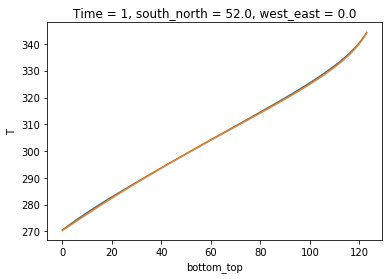

In [16]:
icar_sounding_ds['T'][0,:,52,0].plot()
icar_sounding_ds['T'][1,:,52,0].plot()

#plt.plot(qv_arr)


In [32]:
th_arr_snding = icar_sounding_ds['T'][0,:,0,200]
z_arr_snding  = icar_sounding_ds['PH'][0,:,0,200]
for n, z in enumerate(z_arr_snding):
    
    if n < len(z_arr)-1:
        N_arr[n]  = np.sqrt(9.81*(np.log(th_arr_snding[n+1])-np.log(th_arr_snding[n]))/(z_arr_snding[n+1]-z_arr_snding[n]))